<a href="https://colab.research.google.com/github/mferri17/amazon-reviews-sentiment-network-analysis/blob/master/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Reviews Sentiment Analysis - Ferri Marco, Basso Matteo

This project aims to experiment with sentiment analysis on [Amazon Reviews](http://jmcauley.ucsd.edu/data/amazon/) in order to build a prediction model for rating, based on NLP.

## Dataset

### Dependencies

In [0]:
import os
import gzip
import fileinput
import sys
import datetime
import io
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reading


Util functions to read from JSON and convert into pandas dataframe:

In [0]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  df = []
  for d in parse(path):
    df.append(d)
  return pd.DataFrame(df)

def read_dataset(dataset):      
    basepath = r"datasets\amazon-5-core"
    df = getDF(os.path.join(basepath, dataset))
    return df
  
def download_dataset(dataset):
    request = urllib.request.Request('http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/' + dataset)
    request.add_header('Accept-encoding', 'gzip')
    response = urllib.request.urlopen(request)
    buf = io.BytesIO(response.read())
    file = gzip.GzipFile(fileobj=buf)
    df = []
    for line in file:
      df.append(eval(line))
    return pd.DataFrame(df)

Reading from JSON

In [347]:
#%time dfull = read_dataset("reviews_Video_Games_5.json.gz")
%time dfull = download_dataset('reviews_Sports_and_Outdoors_5.json.gz')

CPU times: user 18.4 s, sys: 334 ms, total: 18.8 s
Wall time: 2min 17s


#### Reading performance

!pip install py-heat-magic
%load_ext heat

%%heat
import os
import gzip
import fileinput
import re
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  df = []
  for d in parse(path):
    df.append(d)
  return pd.DataFrame(df)

def read_dataset(dataset):
    basepath = r"datasets\amazon-5-core"
    df = getDF(os.path.join(basepath, dataset))
    return df

dfull = read_dataset("reviews_Video_Games_5.json.gz")

![reading performances](https://github.com/mferri17/amazon-reviews-sentiment-network-analysis/blob/master/docs/images/00_dataset_reading_performances.png?raw=true)

---

###  Description

#### Schema

In [348]:
dfull.shape

(296337, 9)

In [0]:
dfull = dfull.rename(index=str, columns={"asin": "productID", 
                                         "reviewerID": "userID", 
                                         "reviewerName": "userName",
                                         "reviewText": "text",
                                         "overall": "rating"})

In [350]:
dfull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296337 entries, 0 to 296336
Data columns (total 9 columns):
productID         296337 non-null object
helpful           296337 non-null object
rating            296337 non-null float64
text              296337 non-null object
reviewTime        296337 non-null object
userID            296337 non-null object
userName          294935 non-null object
summary           296337 non-null object
unixReviewTime    296337 non-null int64
dtypes: float64(1), int64(1), object(7)
memory usage: 22.6+ MB


Little dataset preview:

In [351]:
dfull.head(3)

,productID,helpful,rating,text,reviewTime,userID,userName,summary,unixReviewTime
0,1881509818,"[0, 0]",5.0,This came in on time and I am veru happy with ...,"01 26, 2014",AIXZKN4ACSKI,David Briner,Woks very good,1390694400
1,1881509818,"[1, 1]",5.0,I had a factory Glock tool that I was using fo...,"02 2, 2012",A1L5P841VIO02V,Jason A. Kramer,Works as well as the factory tool,1328140800
2,1881509818,"[2, 2]",4.0,If you don't have a 3/32 punch or would like t...,"02 28, 2012",AB2W04NI4OEAD,J. Fernald,"It's a punch, that's all.",1330387200


#### Columns analysis

##### Users and products

In [352]:
(rows,cols) = dfull.shape
n_users = dfull['userID'].nunique()
n_products = dfull['productID'].nunique()
print("Number of REVIEWS: ", rows)
print("Number of USERS: ", n_users)
print("Number of PRODUCTS: ", n_products)
print("Avarage REVIEWS PER USER: ", rows/n_users)
print("Avarage REVIEWS PER PRODUCT: ", rows/n_products)

Number of REVIEWS:  296337
Number of USERS:  35598
Number of PRODUCTS:  18357
Avarage REVIEWS PER USER:  8.324540704533963
Avarage REVIEWS PER PRODUCT:  16.142997221768262


##### Datetime

In [353]:
dfull['date'] = pd.to_datetime(dfull['unixReviewTime'],unit='s')
print("First date: ", min(dfull['date']))
print("Last date: ", max(dfull['date']))

First date:  2002-03-07 00:00:00
Last date:  2014-07-23 00:00:00


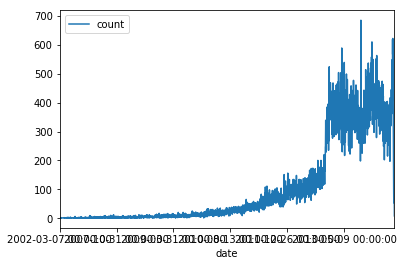

In [354]:
date_grouping = dfull.groupby('date').count()[['rating']].sort_values('date', ascending=True)
date_grouping = date_grouping.rename(index=str, columns={"rating": "count"})
date_grouping.plot()

##### Rating

In [355]:
dfull['rating'].mean()

4.393450699710128

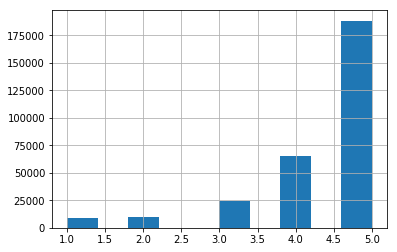

In [356]:
dfull['rating'].hist()

### Manipulation

#### Rejecting columns

In [0]:
dfull = dfull.drop(['helpful', 'reviewTime', 'unixReviewTime', 'userName'], axis = 1)

#### Binarization

In [358]:
dfull['sentiment'] = ['positive' if r > 3 else 'negative' for r in dfull['rating']]
dfull['sentiment'].value_counts()
#dfull.sentiment.hist()

positive    253017
negative     43320
Name: sentiment, dtype: int64

***

## Sentiment Analysis

### Dependencies

In [359]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')

from PIL import Image
from wordcloud import WordCloud

from collections import Counter
import itertools


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Text pre-processing

**Tokenizer**

In [0]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[^\d\W][\w\']*') # preserve words but not numbers preserving contractions

**Stop words**

In [361]:
#stopset = set(stopwords.words('english')) # too aggressive
stopset = {
    'a', 'ain', 'and', 'any', 'are', 'as', 'at', 
    'be', 'because', 'being', 'between', 'both', 'by', 
    'doing', 'during', 'each', 'few', 'for', 'from', 'further', 
    'has', 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 
    'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 
    'is', 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'my', 'myself', 
    'now', 'o', 'of', 'off', 'on', 'once', 'or', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 
    're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'so', 'some', 'such', 
    't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 
    'there', 'these', 'they', 'this', 'those', 'through', 'to', 'until', 'up', 've', 
    'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'with', 
    'y', 'you', "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'}

print(list(stopset))

['themselves', 're', 'own', 'yourself', 'because', 'there', "should've", 'itself', 'has', 'into', 'doing', 'theirs', 'such', 'shan', 's', 'both', 'o', 'by', 'they', 'here', 'yours', 'who', 'to', 'a', 'once', 'how', 'we', 'myself', 'himself', "it's", 'being', 'this', 'i', 'ma', 'the', 'y', 'm', 'them', 'haven', 'than', 'were', 'it', 'which', 'so', "you're", 'off', 'further', 'as', 'same', 'she', 'until', 'then', 'our', 'of', 'or', 'your', 'any', 'is', 'his', 'll', 'yourselves', 'when', 'have', 'with', 'he', 'now', 'each', 'from', 've', 'on', 'her', 'up', 'that', 'between', 'are', 'whom', "that'll", 'ours', "haven't", 'him', 'what', 'be', 'ourselves', 'its', 'at', 'was', 'through', 'should', 'my', 'during', 'for', 'and', 'just', 'their', 'in', 'having', 'me', 'if', 'those', 'these', 'some', 'where', 'while', 'you', "you've", 'few', 't', 'hers', "she's", 'out', 'why', 'herself', "shan't", 'over', 'ain']


**Stemmer**

In [0]:
stemmer = SnowballStemmer('english')

**Example**

In [363]:
text = "Hi! This... isn't a beautiful sentence with some interesting $70 and €5,50 features like people's names and Mr. Fox thoughts for number such as 23, 4 and 7 or peer2peer and wi-fi with snake_case but not kebab-case."
print("TEXT: ", text) # original

# tokenizing
tokens = tokenizer.tokenize(text)
print("TOKENIZED: ", tokens)

# lowercasing
tokens = [t.lower() for t in tokens] 
print("LOWERCASED: ", tokens)

# removing stopwords
tokens = [t for t in tokens if not t in stopset]  
print("NO STOPWORDS: ", tokens)

# stemming
tokens = [stemmer.stem(t) for t in tokens]
print("STEMMED: ", tokens)

TEXT:  Hi! This... isn't a beautiful sentence with some interesting $70 and €5,50 features like people's names and Mr. Fox thoughts for number such as 23, 4 and 7 or peer2peer and wi-fi with snake_case but not kebab-case.
TOKENIZED:  ['Hi', 'This', "isn't", 'a', 'beautiful', 'sentence', 'with', 'some', 'interesting', 'and', 'features', 'like', "people's", 'names', 'and', 'Mr', 'Fox', 'thoughts', 'for', 'number', 'such', 'as', 'and', 'or', 'peer2peer', 'and', 'wi', 'fi', 'with', 'snake_case', 'but', 'not', 'kebab', 'case']
LOWERCASED:  ['hi', 'this', "isn't", 'a', 'beautiful', 'sentence', 'with', 'some', 'interesting', 'and', 'features', 'like', "people's", 'names', 'and', 'mr', 'fox', 'thoughts', 'for', 'number', 'such', 'as', 'and', 'or', 'peer2peer', 'and', 'wi', 'fi', 'with', 'snake_case', 'but', 'not', 'kebab', 'case']
NO STOPWORDS:  ['hi', "isn't", 'beautiful', 'sentence', 'interesting', 'features', 'like', "people's", 'names', 'mr', 'fox', 'thoughts', 'number', 'peer2peer', 'wi',

**On dataset**

In [375]:
pd.set_option('display.max_columns', 150)


def text_processing():

  reviews = dfull['text']
  reviews = reviews.apply(tokenizer.tokenize)
  reviews = reviews.apply(lambda tokens_list: [token.lower() for token in tokens_list])
  reviews = reviews.apply(lambda tokens_list: [token for token in tokens_list if token not in stopset])
  #reviews = reviews.apply(lambda tokens_list: [stemmer.stem(token) for token in tokens_list])

  summaries = dfull['summary']
  summaries = summaries.apply(tokenizer.tokenize)
  summaries = summaries.apply(lambda tokens_list: [token.lower() for token in tokens_list])
  summaries = summaries.apply(lambda tokens_list: [token for token in tokens_list if token not in stopset])
  #summaries = summaries.apply(lambda tokens_list: [stemmer.stem(token) for token in tokens_list])
  
  
%time text_processing()

CPU times: user 29.8 s, sys: 1.55 s, total: 31.4 s
Wall time: 31.3 s


In [376]:
dfull['text_tokens'] = reviews
dfull['summary_tokens'] = summaries
dfull['text_normalized'] = reviews.apply(lambda tokens_list: ' '.join(tokens_list))
dfull['summary_normalized'] = summaries.apply(lambda tokens_list: ' '.join(tokens_list))
dfull.head(5)

,productID,rating,text,userID,summary,date,sentiment,text_tokens,summary_tokens,text_normalized,symmary_normalized,summary_normalized
0,1881509818,5.0,This came in on time and I am veru happy with ...,AIXZKN4ACSKI,Woks very good,2014-01-26,positive,"[came, time, am, veru, happy, haved, used, alr...","[woks, very, good]",came time am veru happy haved used already mak...,woks very good,woks very good
1,1881509818,5.0,I had a factory Glock tool that I was using fo...,A1L5P841VIO02V,Works as well as the factory tool,2012-02-02,positive,"[had, factory, glock, tool, using, glock, i've...","[works, well, factory, tool]",had factory glock tool using glock i've since ...,works well factory tool,works well factory tool
2,1881509818,4.0,If you don't have a 3/32 punch or would like t...,AB2W04NI4OEAD,"It's a punch, that's all.",2012-02-28,positive,"[don't, punch, would, like, one, glock, bag, o...","[punch, that's, all]",don't punch would like one glock bag okay butt...,punch that's all,punch that's all
3,1881509818,4.0,This works no better than any 3/32 punch you w...,A148SVSWKTJKU6,It's a punch with a Glock logo.,2012-02-05,positive,"[works, no, better, punch, would, find, hardwa...","[punch, glock, logo]",works no better punch would find hardware stor...,punch glock logo,punch glock logo
4,1881509818,4.0,I purchased this thinking maybe I need a speci...,AAAWJ6LW9WMOO,"Ok,tool does what a regular punch does.",2013-04-23,positive,"[purchased, thinking, maybe, need, special, to...","[ok, tool, does, regular, punch, does]",purchased thinking maybe need special tool eas...,ok tool does regular punch does,ok tool does regular punch does


### Common Words

In [0]:
# sentences = (list(itertools.chain(dfull)))
# flat_list = [item for sublist in sentences for item in sublist]
  
# fig = plt.figure(figsize=(20,14))
# wordcloud = WordCloud(background_color="white").generate(" ".join(flat_list))
# plt.imshow(wordcloud,interpolation='bilinear')
# plt.axis("off")



---



## Machine Learning

### Undersampling

In [399]:
from sklearn.utils import *

# Separate majority and minority classes
positive_count = dfull['sentiment'].value_counts()['positive']
negative_count = dfull['sentiment'].value_counts()['negative']
df_majority = dfull[dfull.sentiment==('positive' if positive_count >= negative_count else 'negative')]
df_minority = dfull[dfull.sentiment==('negative' if positive_count >= negative_count else 'positive')]
 
# Downsample majority class
obj_samples = negative_count if positive_count >= negative_count else positive_count
df_majority_downsampled = resample(df_majority, 
                                 replace=False,
                                 n_samples = obj_samples, # match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['sentiment'].value_counts()

negative    43320
positive    43320
Name: sentiment, dtype: int64

### TF-IDF (term frequency - inverse document frequency)

In [400]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_downsampled = df_downsampled.drop(['rating'], axis = 1) # directly infers sentiment

tvec = TfidfVectorizer(use_idf=True,
                       strip_accents=None,
                       stop_words=None,
                       lowercase=False) # Tf-idf settings

Y = df_downsampled.sentiment
X = tvec.fit_transform(df_downsampled.summary_normalized) # learning vocabulary and idf

print(Y.shape) # actual target
print(X.shape) # Tf-idf-weighted document-term matrix

(86640,)
(86640, 15123)


### Term Weights

In [401]:
weights = np.asarray(X.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
5559,great,0.044849
5455,good,0.034516
8729,not,0.031376
14822,works,0.021034
1745,but,0.020693
8625,nice,0.017409
8877,ok,0.016891
9993,product,0.015933
9926,price,0.013778
14288,very,0.013346


### Splitting training and test set

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = True)

### Models

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import naive_bayes
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [410]:
forest = RandomForestClassifier(n_estimators = 10)
%time forest.fit(X_train, Y_train)

print()

predictions = forest.predict(X_test)
print("Random Forest confusion matrix")
print(metrics.classification_report(Y_test, predictions))
print("Random Forest Accuracy: ", np.mean(predictions == Y_test)) # comparing predictions with actual
pred_probs = forest.predict_proba(X_test)[:,1] # prediction probabilities for positive class
print("Random Forest AUROC: ", metrics.roc_auc_score(Y_test, pred_probs)) # AUC

CPU times: user 32 s, sys: 13.2 ms, total: 32 s
Wall time: 32 s

Random Forest confusion matrix
              precision    recall  f1-score   support

    negative       0.78      0.83      0.81     12982
    positive       0.82      0.77      0.79     13010

    accuracy                           0.80     25992
   macro avg       0.80      0.80      0.80     25992
weighted avg       0.80      0.80      0.80     25992

Random Forest Accuracy:  0.8004770698676515
Random Forest AUROC:  0.8774344948264557


In [411]:
bayes = naive_bayes.MultinomialNB()
%time bayes.fit(X_train, Y_train)

print()

predictions = bayes.predict(X_test)
print("Bayes confusion matrix")
print(metrics.classification_report(Y_test, predictions))
print("Bayes Accuracy: ", np.mean(predictions == Y_test)) # comparing predictions with actual
pred_probs = bayes.predict_proba(X_test)[:,1] # prediction probabilities for positive class
print("Bayes AUROC: ", metrics.roc_auc_score(Y_test, pred_probs)) # AUC

CPU times: user 158 ms, sys: 1 ms, total: 159 ms
Wall time: 164 ms

Bayes confusion matrix
              precision    recall  f1-score   support

    negative       0.80      0.78      0.79     12982
    positive       0.79      0.80      0.79     13010

    accuracy                           0.79     25992
   macro avg       0.79      0.79      0.79     25992
weighted avg       0.79      0.79      0.79     25992

Bayes Accuracy:  0.7922437673130194
Bayes AUROC:  0.8735269025604068


In [412]:
svm = SGDClassifier(loss='log')
%time svm.fit(X_train, Y_train)

print()

predictions = svm.predict(X_test)
print("SVM confusion matrix")
print(metrics.classification_report(Y_test, predictions))
print("SVM Accuracy: ", np.mean(predictions == Y_test)) # comparing predictions with actual
pred_probs = svm.predict_proba(X_test)[:,1] # prediction probabilities for positive class
print("SVM AUROC: ", metrics.roc_auc_score(Y_test, pred_probs)) # AUC

CPU times: user 212 ms, sys: 84 ms, total: 296 ms
Wall time: 191 ms

SVM confusion matrix
              precision    recall  f1-score   support

    negative       0.80      0.81      0.81     12982
    positive       0.81      0.80      0.81     13010

    accuracy                           0.81     25992
   macro avg       0.81      0.81      0.81     25992
weighted avg       0.81      0.81      0.81     25992

SVM Accuracy:  0.8069021237303786
SVM AUROC:  0.8860323452646727


---